The code below uses the colors from a GIMP color palette (stored in `palette_uncalibrated.py`) together with the flatbed scanner ICC profile to generate a calibrated color key stored in a CSV file, along with color values in multiple color spaces: RGB, CIE XYZ/Lab and Munsell.

Generating the Munsell values takes a considerate amount of time, so only do this when needed.

Packages needed: numpy, pandas, pillow, colour science (package `colour-science`)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageCms
import palette_uncalibrated
import color_conv

rgb_colors = np.array( [[ tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for h in list(palette_uncalibrated.colors.values()) ]] )

input_profile = ImageCms.getOpenProfile("./icc_profiles/icc_profile_epson1200u.icm")
output_profile = ImageCms.getOpenProfile("./icc_profiles/ColorMatchRGB.icc")
transform = ImageCms.ImageCmsTransform(input_profile, output_profile, input_mode="RGB", output_mode="RGB")

img = Image.fromarray(rgb_colors.astype('uint8'), 'RGB')
img_conv = ImageCms.applyTransform(img, transform)

display(img)
display(img_conv)

data = []
for key, uncalib, calib in zip(palette_uncalibrated.colors.keys(), palette_uncalibrated.colors.values(), np.array(img_conv)[0]):
    hex_calib = '#%02x%02x%02x' % tuple(calib)
    XYZ = color_conv.rgb2xyz(calib, "D50")
    lab = color_conv.xyz2lab(XYZ)
    xyY = color_conv.xyz2xyy(XYZ)
#     try:
#         # WARNING this takes around a minute to complete, so only uncomment when you want to generate the Munsell names!
#         munsell = color_conv.xyy2munsell(xyY)
#     except:
#         # when color is outside the Munsell gamut, the routine throws an exception. How convenient :(
#         munsell = ""
    munsell = ""
    data.append([key, hex_calib, *list(calib), *lab, *XYZ, *xyY, munsell])

df = pd.DataFrame(data, columns=['ColorName', 'RGBhex', 'RGB_R', 'RGB_G', 'RGB_B', 'CIELab_L', 'CIELab_a', 'CIELab_b', 'CIEXYZ_X', 'CIEXYZ_Y', 'CIEXYZ_Z', 'CIExyY_x', 'CIExyY_y', 'CIExyY_Y', 'munsell'])
print(df.head())
df.to_csv("./color_key_calibrated.csv")

      ColorName   RGBhex  RGB_R  RGB_G  RGB_B  CIELab_L  CIELab_a  CIELab_b  \
0         Slate  #7e6c87    126    108    135   48.1480     11.05    -24.12   
1    SlateBlack  #252e3f     37     46     63   18.8348      0.50    -18.94   
2  BrownishGrey  #c0a094    192    160    148   68.3784      8.15     -2.40   
3  GreenishGrey  #bab7ad    186    183    173   74.3988     -2.60     -9.12   
4     OliveGrey  #827057    130    112     87   48.2872      1.75      7.38   

   CIEXYZ_X  CIEXYZ_Y  CIEXYZ_Z  CIExyY_x  CIExyY_y  CIExyY_Y munsell  
0    0.5751    0.5530    0.6736    0.3192    0.3069    0.5530          
1    0.3013    0.3003    0.3950    0.3023    0.3013    0.3003          
2    0.7437    0.7274    0.7394    0.3364    0.3291    0.7274          
3    0.7741    0.7793    0.8249    0.3255    0.3277    0.7793          
4    0.5577    0.5542    0.5173    0.3423    0.3402    0.5542          


See below for some visualization; the 

   Unnamed: 0     ColorName   RGBhex  RGB_R  RGB_G  RGB_B  CIELab_L  CIELab_a  \
0           0         Slate  #7e6c87    126    108    135   48.1480     11.05   
1           1    SlateBlack  #252e3f     37     46     63   18.8348      0.50   
2           2  BrownishGrey  #c0a094    192    160    148   68.3784      8.15   
3           3  GreenishGrey  #bab7ad    186    183    173   74.3988     -2.60   
4           4     OliveGrey  #827057    130    112     87   48.2872      1.75   

   CIELab_b  CIEXYZ_X  CIEXYZ_Y  CIEXYZ_Z  CIExyY_x  CIExyY_y  CIExyY_Y  \
0    -24.12    0.5751    0.5530    0.6736    0.3192    0.3069    0.5530   
1    -18.94    0.3013    0.3003    0.3950    0.3023    0.3013    0.3003   
2     -2.40    0.7437    0.7274    0.7394    0.3364    0.3291    0.7274   
3     -9.12    0.7741    0.7793    0.8249    0.3255    0.3277    0.7793   
4      7.38    0.5577    0.5542    0.5173    0.3423    0.3402    0.5542   

   munsell  
0      NaN  
1      NaN  
2      NaN  
3      NaN

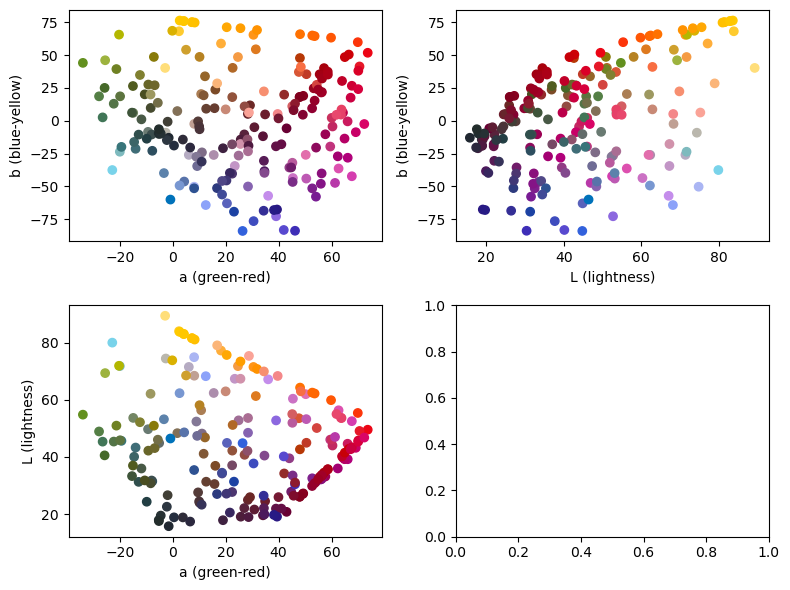

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./color_key_calibrated.csv")
print(df.head())

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))
ax[0][0].scatter(df["CIELab_a"], df["CIELab_b"], c=df["RGBhex"])
ax[0][0].set_xlabel("a (green-red)")
ax[0][0].set_ylabel("b (blue-yellow)")
ax[0][1].scatter(df["CIELab_L"], df["CIELab_b"], c=df["RGBhex"])
ax[0][1].set_xlabel("L (lightness)")
ax[0][1].set_ylabel("b (blue-yellow)")
ax[1][0].scatter(df["CIELab_a"], df["CIELab_L"], c=df["RGBhex"])
ax[1][0].set_xlabel("a (green-red)")
ax[1][0].set_ylabel("L (lightness)")

plt.tight_layout()
plt.show()
